# BreizhCrops Evaluation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
from argparse import Namespace
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from models.earlyrnn import EarlyRNN
import torch
import os
import pandas as pd
from datetime import datetime
import numpy as np
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, recall_score, precision_score

import datetime
import seaborn

import os
import pandas as pd
from datetime import datetime
import numpy as np

import datetime
import seaborn
import datetime
import breizhcrops as bzh
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
from utils.plots import plot_label_distribution_datasets
from utils.helpers_config import set_up_config, save_config, print_config
from utils.test.helpers_testing import get_test_stats_from_model, load_test_dataset, save_test_stats
from utils.plots_test import plots_all_figs_at_test
import matplotlib.pyplot as plt
from utils.test.load_model import get_all_runs, get_loaded_model_and_criterion, get_model_and_model_path
from utils.helpers_mu import get_mus_from_config
from utils.results_analysis.extract_video import download_images, add_files_to_images, save_video
import argparse


# load model

In [3]:
local_dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")


In [4]:
run_name = "silver-sweep-12"
print(f"Load model from run '{run_name}'")

# ## Download the model from wandb 
entity, project = "aurenore", "MasterThesis"
runs_df, runs = get_all_runs(entity, project)

# get the run with name:
run_idx = runs_df[runs_df.name == run_name].index[0]
run = runs[run_idx]
run_config = argparse.Namespace(**run.config)
model_artifact, model_path = get_model_and_model_path(run)

# get and save the config
config_path = save_config(model_path, run)
print_config(run)
args  = set_up_config(run_config)
args.dataroot = local_dataroot #data_root


Load model from run 'silver-sweep-12'


wandb:   1 of 1 files downloaded.  


config file saved at:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\notebooks\artifacts\run-ztfrf9yy-model.pth-v22\config.json
-------------------------------------------------- Configuration: --------------------------------------------------
mu: 150
mus: [167, 102, 25, 113, 150, 150, 150]
loss: daily_reward_piecewise_lin_regr
alpha: 1
device: cuda
epochs: 100
factor: v2
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /home/amauron/elects/data/elects_data
p_thresh: 0.7
patience: 30
snapshot: /home/amauron/elects/data/elects_snapshots/model.pth
batchsize: 256
corrected: True
alpha_decay: [1, 0.5]
hidden_dims: 128
loss_weight: balanced
weight_decay: 0
backbonemodel: LSTM
class_weights: [0.04731182754039765, 0.02670983411371708, 0.14316703379154205, 0.01290007308125496, 1, 0.011567785404622557, 0.010797104798257353]
decision_head: day
learning_rate: 0.001
nb_parameters: 264994
sequencelength: 365
validation_set: valid
daily_timestamps: True
day_head_init_bias: None
percentag

In [5]:
# ----------------------------- LOAD DATASET -----------------------------
# Set the sequence length to 150 like in the original paper.
sequencelength_test = run_config.sequencelength
args.preload_ram = True
test_ds, nclasses, class_names, input_dim = load_test_dataset(args, sequencelength_test)

2493572704 2493572704
1555075632 1555075632
class names: ['barley' 'wheat' 'rapeseed' 'corn' 'orchards' 'permanent meadows'
 'temporary meadows']


In [6]:
# ## Load the models and the criterions
mus = get_mus_from_config(run_config)
model, criterion = get_loaded_model_and_criterion(run, nclasses, input_dim, mus=mus)

# ## Test the model on the test dataset
test_stats, stats = get_test_stats_from_model(model, test_ds, criterion, run_config)

wandb:   1 of 1 files downloaded.  
c:\Users\anyam\Desktop\Master_thesis\Code\elects\notebooks\..\utils\test\load_model.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(run_config.class_weights)


loss daily_reward_piecewise_lin_regr selected, mus set to tensor([167, 102,  25, 113, 150, 150, 150])
model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\notebooks\artifacts\run-ztfrf9yy-model.pth-v22
The model has 264,994 trainable parameters.
weights moved to device cuda


## Qualitative Plots in a window

c:\Users\anyam\Desktop\Master_thesis\Code\elects\notebooks\..\data\breizhcrops.py:366: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  geodataframe["geometry"] = geom["geometry"]


<Axes: >

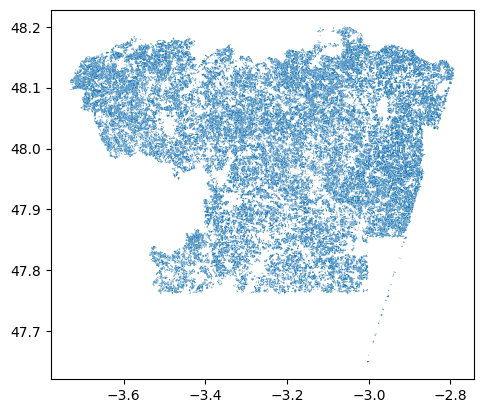

In [7]:
import geopandas as gpd
from shapely.geometry import Polygon
crs = 4326
gdf = test_ds.ds_2.geodataframe().to_crs(crs)
gdf.plot()

In [8]:
min_x = -3.15
max_x = -3.1
min_y = 48.1
max_y = 48.08
coords = [[min_x, max_y],
          [min_x, min_y],
          [max_x, min_y],
          [max_x, max_y]]

polygon_geom = Polygon(coords)
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])    


In [9]:
fields = gdf.sjoin(polygon, how="inner")

<Axes: >

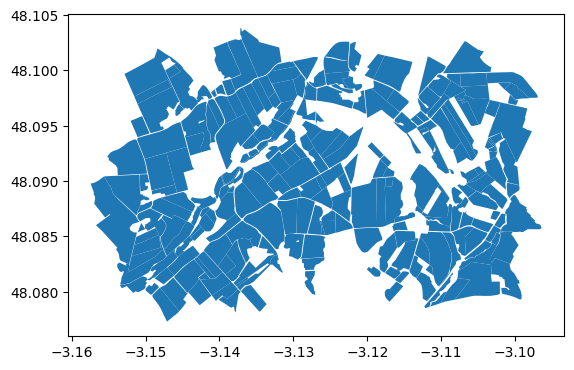

In [10]:
fields.plot()

In [22]:
# select subset of stats
msk = np.isin(stats["ids"][:,0], fields.id.values)
msk.sum()
print("Number of fields in the selected area: ", msk.sum())
print("shape of msk: ", msk.shape)

sel_stats = {}
for k,v in stats.items():
    if v.shape[0] == msk.shape[0]:
        sel_stats[k] = v[msk]
        print(f"added {k} with shape {v[msk].shape}")
print("-"*20)
if args.daily_timestamps:
    print("get the doys from t_stop.")
    doy_stop = stats["t_stop"].squeeze()[msk]
else: 
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    doy_stop = get_doy_stop(sel_stats, doys_dict_test, approximated=False)
# doy_stop = []
# for id, t_stop in zip(sel_stats["ids"][:,0], sel_stats["t_stop"][:,0]):
#     doys = doys_dict.flat[0][id]
#     doy_stop.append(doys[t_stop-1])
sel_stats["doy_stop"] = doy_stop

summary = pd.DataFrame(
    [sel_stats["ids"][:,0], sel_stats["doy_stop"], sel_stats["predictions_at_t_stop"][:,0], sel_stats["targets"][:,0]], 
                       index=["id","doy_stop","predictions_at_t_stop","targets"]).T.set_index("id")

Number of fields in the selected area:  229
shape of msk:  (39378,)
added timestamps_left with shape (229, 365)
added class_probabilities with shape (229, 365, 7)
added predictions_at_t_stop with shape (229, 1)
added t_stop with shape (229, 1)
added targets with shape (229, 365)
added ids with shape (229, 1)
added seqlengths with shape (229,)
--------------------
get the doys from t_stop.


In [23]:
summary

,doy_stop,predictions_at_t_stop,targets
id,,,
6018950,165,6,6
6018951,146,3,3
6018952,166,6,6
6018953,169,0,0
6018954,146,5,5
...,...,...,...
6173208,143,3,3
6173209,142,3,3
6173210,155,6,6


In [24]:
annot_fields = fields.set_index("id").join(summary)
annot_fields["correct"] = annot_fields["targets"] == annot_fields["predictions_at_t_stop"]
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

canard = "#007480"
grosseile = "#b51f1f"
rouge = "#FF0000"
leman = "#00A79F"
acier = "#4F8FCC"


newcmp = ListedColormap([grosseile, acier])
stopped_cmap = ListedColormap(["white","black"])


classes_cmap = ListedColormap(["#3274A1", "#E1812C", "#3A913A", "#C03D3E", "#886BA3", "#845B53", "#D584BD", "#7F7F7F", "#A9AA35"])

storepath = "/tmp/maps/"
os.makedirs(storepath, exist_ok=True)

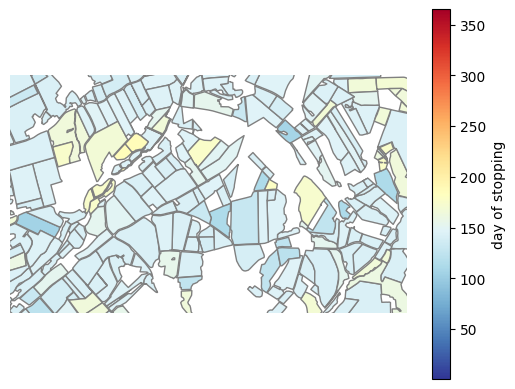

In [30]:
import contextily as cx
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots()

xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis("off")
annot_fields.plot(column="doy_stop", ax=ax, cmap="RdYlBu_r", vmin=1, 
                  vmax=365, legend=True, edgecolor="gray", legend_kwds={'label': 'day of stopping', "orientation": "vertical"})
fig.savefig(os.path.join(storepath,"doy_stop.pdf"), bbox_inches="tight",transparent=True)


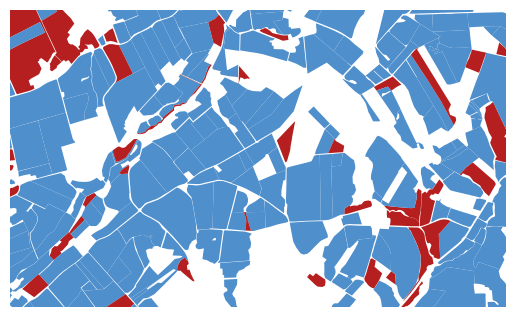

In [31]:
import contextily as cx
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots()


xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis("off")

annot_fields.plot(column="correct", ax=ax, cmap=newcmp)
fig.savefig(os.path.join(storepath,"correct.pdf"), bbox_inches="tight",transparent=True)


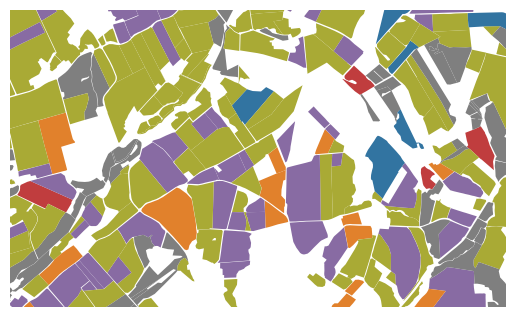

In [27]:
import contextily as cx
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots()

xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis("off")

annot_fields.plot(column="targets", ax=ax, cmap=classes_cmap)
fig.savefig(os.path.join(storepath,"targets.pdf"), bbox_inches="tight",transparent=True)

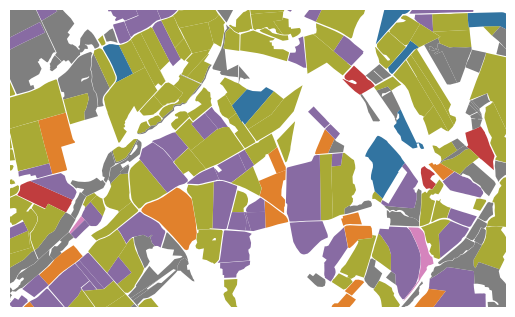

In [28]:
import contextily as cx
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots()


xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis("off")

annot_fields.plot(column="predictions_at_t_stop", ax=ax, cmap=classes_cmap)
fig.savefig(os.path.join(storepath,"predictions.pdf"), bbox_inches="tight",transparent=True)

In [43]:
dates_of_interest = ["2017-06-21","2017-07-16"] #["2017-04-12","2017-05-22","2017-06-21","2017-07-16"]
doys_of_interest = [datetime.datetime.strptime(d,"%Y-%m-%d").timetuple().tm_yday for d in dates_of_interest]

## Qualitative Samples at different times

In [44]:
for key in sel_stats.keys(): 
    print(key, sel_stats[key].shape)

timestamps_left (229, 365)
class_probabilities (229, 365, 7)
predictions_at_t_stop (229, 1)
t_stop (229, 1)
targets (229, 365)
ids (229, 1)
seqlengths (229,)
doy_stop (229,)


date 2017-06-21: accuracy all 0.86
date 2017-06-21: accuracy stopped 0.87
figure saved at  /tmp/maps/correct_at_doy_2017-06-21.pdf
date 2017-07-16: accuracy all 0.86
date 2017-07-16: accuracy stopped 0.86
figure saved at  /tmp/maps/correct_at_doy_2017-07-16.pdf


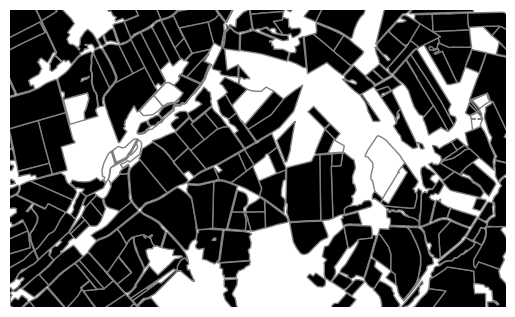

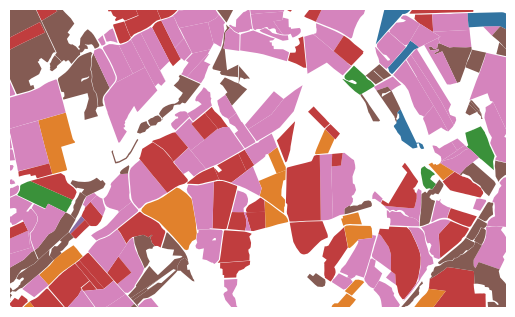

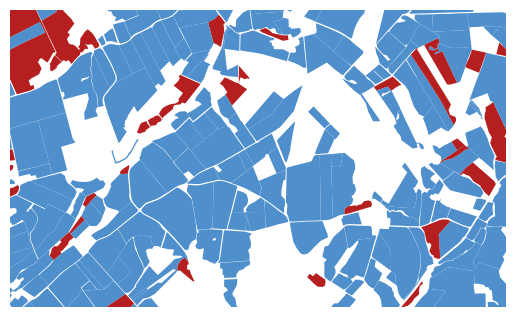

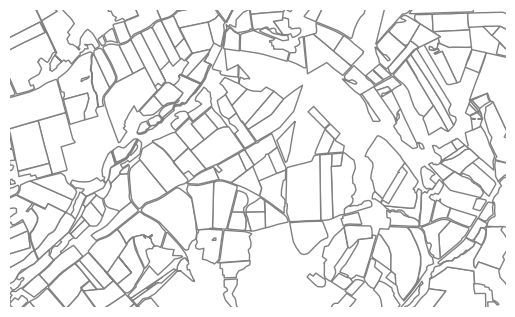

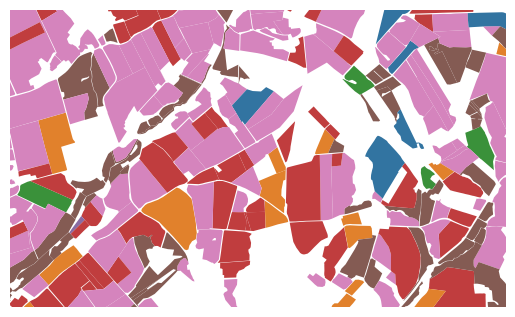

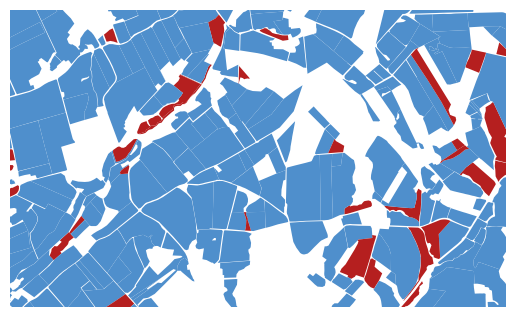

In [51]:
alpha=0.4

for doy, date in zip(doys_of_interest, dates_of_interest):
    annot_fields["stopped_before_doy"] = annot_fields["doy_stop"] < doy
    
    #t_stop = np.argwhere(doys==doy)[0]
    t_stop = doy
    annot_fields["prediction_at_doy"] = sel_stats["class_probabilities"].argmax(2)[:,t_stop]
    
    annot_fields["correct_at_doy"] = annot_fields["prediction_at_doy"] == annot_fields["targets"]
    
    overall_accuracy = annot_fields["correct_at_doy"].mean()
    print(f"date {date}: accuracy all {overall_accuracy:.2f}")
    
    
    overall_accuracy_stopped = annot_fields["correct_at_doy"].loc[annot_fields["stopped_before_doy"]].mean()
    print(f"date {date}: accuracy stopped {overall_accuracy_stopped:.2f}")
    

    fig, ax = plt.subplots()
    xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis("off")
    annot_fields.plot(column="stopped_before_doy", ax=ax, cmap=stopped_cmap,  edgecolor='gray')
    fig.savefig(os.path.join(storepath,f"stopped_at_date_{date}.pdf"), bbox_inches="tight",transparent=True)
    
    fig, ax = plt.subplots()
    xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis("off")
    if annot_fields["stopped_before_doy"].sum() > 0:
        annot_fields.loc[annot_fields["stopped_before_doy"]].plot(column="prediction_at_doy", 
                                                                  ax=ax, cmap=classes_cmap, vmin=0, vmax=8)
        if ~annot_fields["stopped_before_doy"].sum() > 0:
            annot_fields.loc[~annot_fields["stopped_before_doy"]].plot(column="prediction_at_doy", 
                                                                      ax=ax, cmap=classes_cmap, alpha=alpha, vmin=0, vmax=8)
    else:
        annot_fields.plot(column="prediction_at_doy", ax=ax, cmap=classes_cmap, alpha=alpha, vmin=0, vmax=8)
        
    fig.savefig(os.path.join(storepath,f"prediction_at_date_{date}.pdf"), bbox_inches="tight",transparent=True)
    
    fig, ax = plt.subplots()
    xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis("off")
    
    if annot_fields["correct_at_doy"].sum() > 0:
        annot_fields.loc[annot_fields["stopped_before_doy"]].plot(column="correct_at_doy", 
                                                                  ax=ax, cmap=newcmp, vmin=0, vmax=1)
        if ~annot_fields["stopped_before_doy"].sum() > 0:
            annot_fields.loc[~annot_fields["stopped_before_doy"]].plot(column="correct_at_doy", 
                                                                  ax=ax, cmap=newcmp, alpha=alpha, vmin=0, vmax=1)
    else:
        annot_fields.plot(column="correct_at_doy", ax=ax, cmap=newcmp, alpha=alpha, vmin=0, vmax=1)
        
    fig.savefig(os.path.join(storepath,f"correct_at_doy_{date}.pdf"), bbox_inches="tight",transparent=True)
    print("figure saved at ", os.path.join(storepath,f"correct_at_doy_{date}.pdf"))

In [52]:
predictions = stats["predictions_at_t_stop"][:,0]
targets = stats["targets"][:,0]

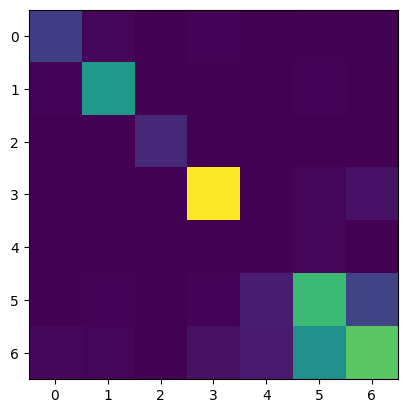

In [53]:
from sklearn.metrics import confusion_matrix, recall_score

plt.imshow(confusion_matrix(targets, predictions))

In [54]:
recalls = recall_score(targets, predictions, average=None)

In [55]:
for cl, acc in zip(classes, recalls):
    print(f"{cl}: {acc:.2f}")

NameError: name 'classes' is not defined